# [★★☆☆☆] Process Ground Motion for Dynamic Analysis

In this example, we mainly introduce and discuss different methods to introduce ground motion into response history analyses.
For different methods, different considerations shall be taken into account.

The ground motion record can be one of acceleration, velocity, or displacement.
Depending on how it is collected, it could either be a processed or raw record.
Typically, seismometer collects acceleration, and velocity and displacement are derived from acceleration.
We assume that analysts are given accelerograms. 

## EOM

The equation of motion is often written as follows, assuming linear elasticity.

$$
\mathbf{M}\ddot{\mathbf{u}}+\mathbf{C}\dot{\mathbf{u}}+\mathbf{K}\mathbf{u}=\mathbf{f}.
$$

To incorporate ground motion in the form of acceleration, one can choose the following methods.

1.  Apply the acceleration on the upper structure, in the form of inertial force, with the assist of the global mass matrix.
    This method involves the global mass matrix $$\mathbf{M}$$, and assumes $$\mathbf{M}$$ is constant, or at least remains constant within the time step.
2.  Apply the ground motion on the supports.
    This method mimics the real-world situation.
    The ground motion is applied on the supports, and the structure is allowed to move freely.
    Thus, final results contain rigid body motion.
    Furthermore, since conventionally displacement is used as the primary unknown, the given acceleration shall be converted to displacement.

## Ground Motion as Inertial Force

The inertial force can be formulated as follows.

$$
\mathbf{f}_g=\mathbf{M}\ddot{\mathbf{u}}_g.
$$

However, when applied in the form of force, there is a risk of unintended spurious force.
One can refer to the paper [10.1080/13632469.2024.2372814](https://doi.org/10.1080/13632469.2024.2372814) for more details.
The conclusion is that, one shall always process the ground motion based on the time step size used in response history analysis, regardless of the source of the ground motion, processed or raw.

## Ground Motion as Support Displacement

The ground motion can also be applied on the supports.
In this case, the ground motion is converted to displacement.
But how?
Naturally, acceleration shall be integrated twice to obtain displacement.
However, the integration process is not straightforward.
Furthermore, not any integration method is suitable for this purpose.

## Example

In [104]:
import json

import numpy as np

with open('process-ground-motion.json', 'r') as f:
    record = json.load(f)

waveform = np.array(record['raw_data'], dtype=float)
waveform /= max(abs(waveform))
dt = record['time_interval']
duration = dt * len(waveform)

Let's peek at the ground motion record.

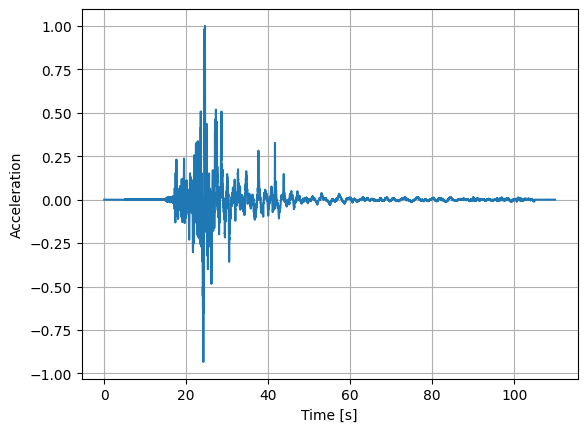

In [105]:
import matplotlib.pyplot as plt


def plot_waveform(_dt, _waveform):
    plt.plot(np.arange(0, _dt * len(_waveform), _dt), _waveform)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration')
    plt.grid(True)


plot_waveform(dt, waveform)

Let's also check the frequency content of the ground motion.
It can be done by Fourier transform.

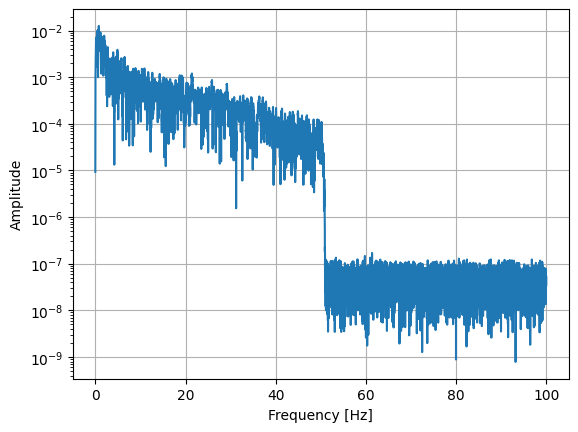

In [106]:
from scipy.fft import rfft, rfftfreq


def plot_freq(_dt, _waveform):
    n = len(_waveform)
    frequencies = rfftfreq(n, _dt)
    fft_values = 2 * np.abs(rfft(_waveform)) / n

    plt.plot(frequencies, fft_values)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.yscale('log')
    plt.grid(True)


plot_freq(dt, waveform)

It appears that the provided ground motion has been filtered using a band-pass filter.
The frequency content above 50 Hz is significantly reduced.

This ground motion is sampled at 200 Hz, with an interval of 0.005 s.
If it is used in a response history analysis with a time step of 0.005 s, the ground motion shall be processed.
The de facto method is to perform linear interpolation.

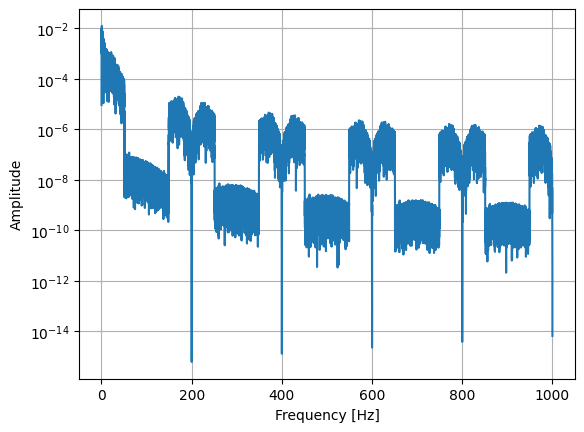

In [107]:
from scipy.interpolate import interp1d

interp_dt = dt / 10
interp_func = interp1d(np.arange(0, duration, dt), waveform)
interp_waveform = interp_func(np.arange(0, duration - dt + interp_dt, interp_dt))
plot_freq(interp_dt, interp_waveform)